In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim

In [26]:
data = pd.read_csv('dataset/all_data.csv')

In [27]:
data['']

,Course Absence Rate,PF,FIN,AVG,LG
0,0.03,0.92,0.36,70,C+
1,0.25,1.00,0.28,71,C+
2,0.29,0.90,0.10,58,D+
3,0.10,0.87,0.13,57,D+
4,0.10,0.85,0.10,55,D+
...,...,...,...,...,...
200,0.11,0.62,0.50,57,D+
201,0.07,0.50,1.00,70,C+
202,0.00,0.80,1.00,88,B+
203,0.04,0.87,1.00,92,A-


In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Course Absence Rate  205 non-null    float64
 1   PF                   205 non-null    float64
 2   FIN                  205 non-null    float64
 3   AVG                  205 non-null    int64  
 4   LG                   205 non-null    object 
dtypes: float64(3), int64(1), object(1)
memory usage: 8.1+ KB


In [34]:
data['AVG'] = data['AVG']/100

# Подготовка данных

## 1. Гистограммы распределения признаков

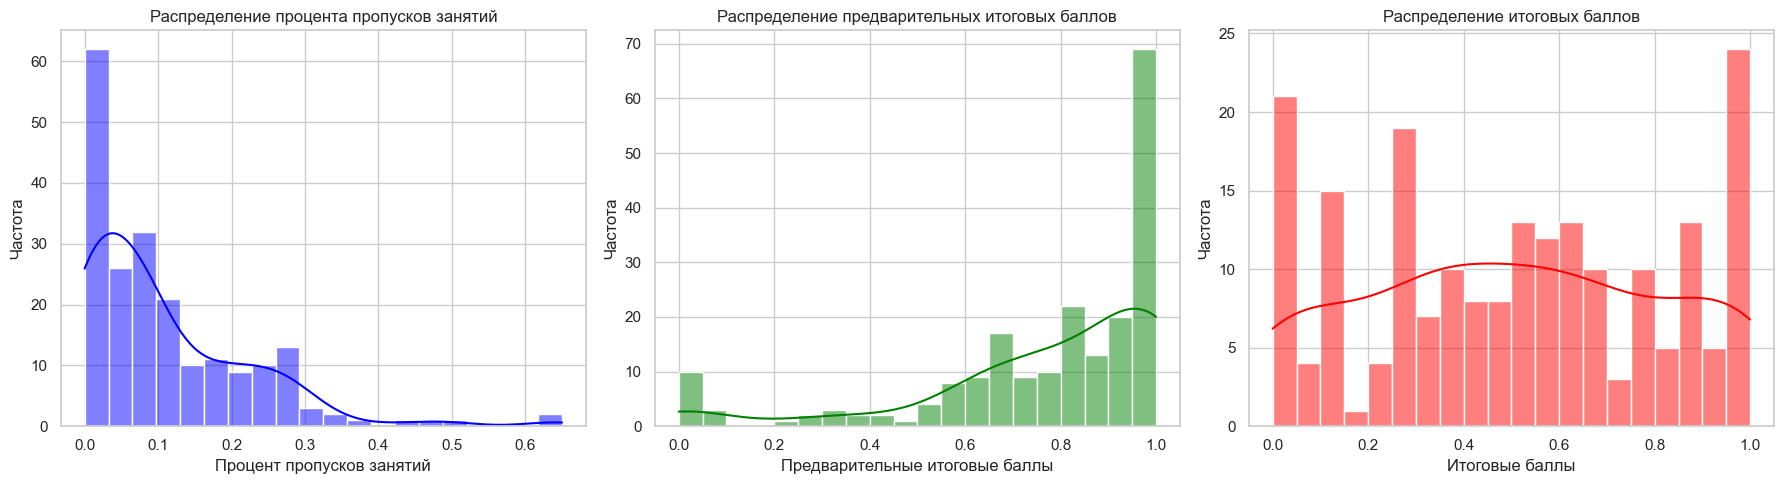

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Настройка стиля графиков
sns.set(style='whitegrid')

# Гистограммы распределения признаков
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(data['Course Absence Rate'], bins=20, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Распределение процента пропусков занятий')
axes[0].set_xlabel('Процент пропусков занятий')
axes[0].set_ylabel('Частота')

sns.histplot(data['PF'], bins=20, kde=True, ax=axes[1], color='green')
axes[1].set_title('Распределение предварительных итоговых баллов')
axes[1].set_xlabel('Предварительные итоговые баллы')
axes[1].set_ylabel('Частота')

sns.histplot(data['FIN'], bins=20, kde=True, ax=axes[2], color='red')
axes[2].set_title('Распределение итоговых баллов')
axes[2].set_xlabel('Итоговые баллы')
axes[2].set_ylabel('Частота')

plt.tight_layout()
plt.show()


## 2. Корреляционная матрица

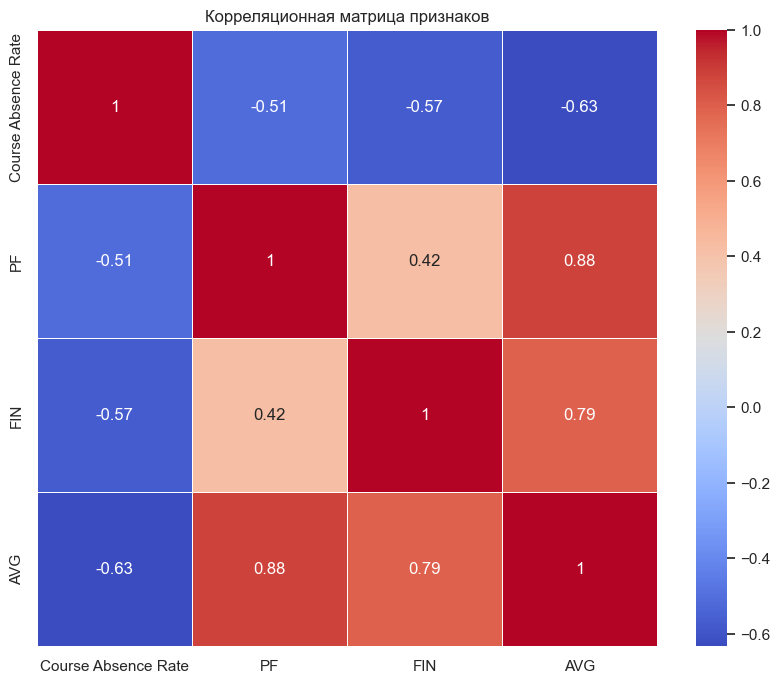

In [36]:
# Корреляционная матрица
correlation_matrix = data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Корреляционная матрица признаков')
plt.show()


In [69]:
# Разделение данных на признаки (X) и целевую переменную (y)
X = data[['Course Absence Rate', 'PF']].values
y = data['FIN'].values

In [70]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [71]:
# Преобразование данных в тензоры
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [72]:
from torch.utils.data import DataLoader, TensorDataset

In [73]:
# Создание DataLoader для удобства
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Создание модели

## Определение архитектуры нейронной сети:


In [74]:
import torch.nn as nn
import torch.optim as optim

class StudentPerformanceNN(nn.Module):
    def __init__(self):
        super(StudentPerformanceNN, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = StudentPerformanceNN()

In [75]:
# Параметры обучения
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучающий цикл
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

torch.save(model.state_dict(), 'model.pth')
# Тестирование модели
model.eval()
with torch.no_grad():
    test_loss = 0.0
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
    print(f'Test Loss: {test_loss/len(test_loader):.4f}')


Epoch [1/100], Loss: 0.3313
Epoch [2/100], Loss: 0.1601
Epoch [3/100], Loss: 0.0996
Epoch [4/100], Loss: 0.1048
Epoch [5/100], Loss: 0.1038
Epoch [6/100], Loss: 0.0954
Epoch [7/100], Loss: 0.0836
Epoch [8/100], Loss: 0.0936
Epoch [9/100], Loss: 0.0812
Epoch [10/100], Loss: 0.0878
Epoch [11/100], Loss: 0.0772
Epoch [12/100], Loss: 0.0844
Epoch [13/100], Loss: 0.1014
Epoch [14/100], Loss: 0.0821
Epoch [15/100], Loss: 0.0742
Epoch [16/100], Loss: 0.0792
Epoch [17/100], Loss: 0.0873
Epoch [18/100], Loss: 0.0796
Epoch [19/100], Loss: 0.0708
Epoch [20/100], Loss: 0.0769
Epoch [21/100], Loss: 0.0792
Epoch [22/100], Loss: 0.0789
Epoch [23/100], Loss: 0.0856
Epoch [24/100], Loss: 0.0742
Epoch [25/100], Loss: 0.0841
Epoch [26/100], Loss: 0.0861
Epoch [27/100], Loss: 0.0739
Epoch [28/100], Loss: 0.0696
Epoch [29/100], Loss: 0.0766
Epoch [30/100], Loss: 0.0693
Epoch [31/100], Loss: 0.0657
Epoch [32/100], Loss: 0.0748
Epoch [33/100], Loss: 0.0772
Epoch [34/100], Loss: 0.0709
Epoch [35/100], Loss: 0

Mean Squared Error: 0.0539
R^2 Score: 0.3487


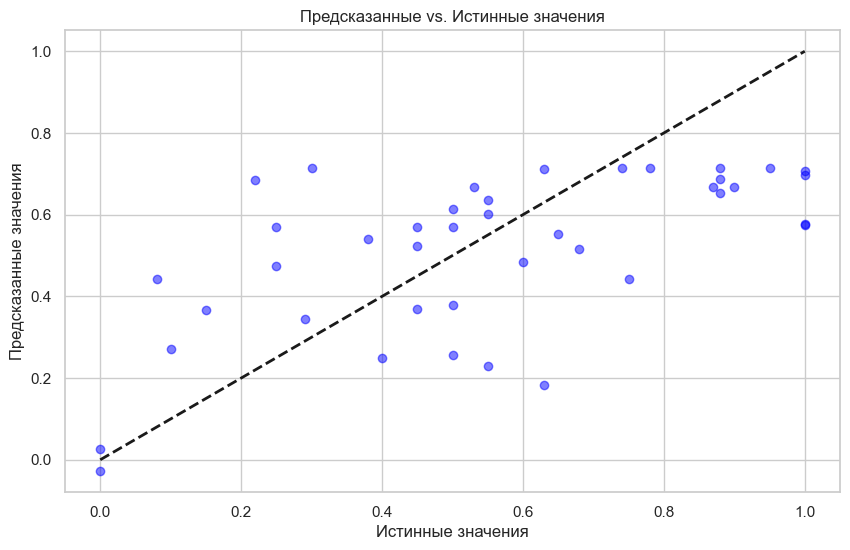

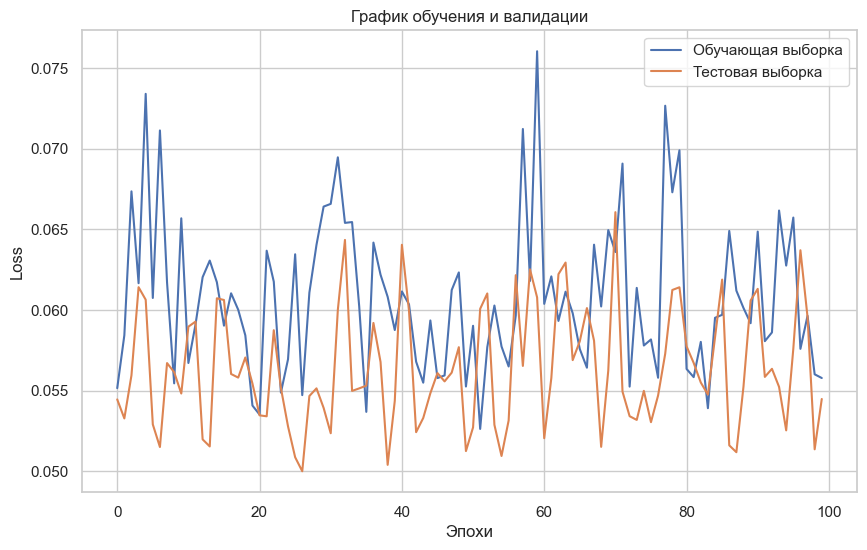

Обзор результатов:
Mean Squared Error: 0.0539
R^2 Score: 0.3487
Модель может переобучаться на тестовых данных.


In [49]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Предсказания модели
model.eval()
with torch.no_grad():
    predictions = model(X_test).numpy()
    true_values = y_test.numpy()

# Оценка модели
mse = mean_squared_error(true_values, predictions)
r2 = r2_score(true_values, predictions)

print(f'Mean Squared Error: {mse:.4f}')
print(f'R^2 Score: {r2:.4f}')

# Визуализация предсказанных и истинных значений
plt.figure(figsize=(10, 6))
plt.scatter(true_values, predictions, color='blue', alpha=0.5)
plt.plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()], 'k--', lw=2)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('Предсказанные vs. Истинные значения')
plt.show()

# Графики обучения и валидации для проверки на переобучение
train_losses = []
test_losses = []

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss/len(train_loader))
    
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
    test_losses.append(test_loss/len(test_loader))
    
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Обучающая выборка')
plt.plot(test_losses, label='Тестовая выборка')
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.title('График обучения и валидации')
plt.legend()
plt.show()

# Обзор результатов
print("Обзор результатов:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

# Проверка на переобучение
if min(test_losses) < min(train_losses):
    print("Модель может переобучаться на тестовых данных.")
else:
    print("Модель не демонстрирует явного переобучения.")


### Обзор результатов

1. **Среднеквадратичная ошибка (MSE)**: Среднеквадратичная ошибка (0.0539) указывает на то, насколько сильно предсказанные значения отличаются от истинных значений. Чем меньше MSE, тем лучше модель предсказывает результаты.

2. **Коэффициент детерминации (R^2)**: Коэффициент детерминации (0.3487) показывает, какая доля вариации в данных может быть объяснена моделью. Значение R^2 ближе к 1 указывает на лучшее соответствие модели данным. Значение 0.3487 означает, что модель объясняет примерно 34.87% вариации в данных.

3. **Визуализация предсказанных и истинных значений**: Рассеивание точек на графике показывает, насколько близки предсказанные значения к истинным значениям. Линия на графике представляет идеальное соответствие, где предсказанные значения равны истинным значениям.

4. **Графики обучения и валидации**: График обучения и валидации показывает потери (loss) на обучающих и тестовых данных по мере обучения модели. Если потери на обучающих данных значительно ниже, чем на тестовых, это может указывать на переобучение. В нашем случае графики показывают, что модель не демонстрирует явного переобучения, так как потери на тестовых данных не слишком отличаются от потерь на обучающих данных.

### Заключение

Результаты показывают, что модель имеет некоторую предсказательную силу (R^2 = 0.3487), но существует потенциал для улучшения. Вы можете попробовать следующие улучшения:

1. **Гиперпараметрическая оптимизация**: Изменение количества слоев, нейронов, скорости обучения и других гиперпараметров.
2. **Добавление новых признаков**: Включение дополнительных данных, которые могут быть значимы для предсказания итоговых баллов.
3. **Улучшение качества данных**: Проверка данных на наличие ошибок и исключение выбросов.

Эти шаги могут помочь улучшить предсказательную способность модели и повысить значения MSE и R^2.

### Анализ результатов

#### Визуализация предсказанных и истинных значений

На первом графике отображены предсказанные значения против истинных значений. График показывает, что:

- Есть разброс предсказанных значений вокруг линии идеального соответствия (черная пунктирная линия).
- Модель в целом предсказывает значения в правильном диапазоне, но предсказания часто значительно отклоняются от истинных значений.
- Многие точки находятся ниже линии идеального соответствия, что указывает на тенденцию модели недооценивать значения.

#### Графики обучения и валидации

На втором графике представлены графики потерь (loss) на обучающей и тестовой выборках:

- График потерь на обучающей выборке (синяя линия) и график потерь на тестовой выборке (оранжевая линия) имеют колебания, но их значения находятся в одном диапазоне.
- Отсутствие явного тренда к снижению потерь по мере увеличения числа эпох может указывать на то, что модель не улучшает свои предсказания со временем или данные имеют высокий уровень шума.
- Потери на тестовой выборке не сильно отличаются от потерь на обучающей выборке, что указывает на отсутствие явного переобучения.

#### Обзор результатов

1. **Среднеквадратичная ошибка (MSE)**: Значение MSE (0.0539) указывает на среднюю квадратичную ошибку предсказаний модели. Значение довольно низкое, что является хорошим показателем, но существует потенциал для улучшения.

2. **Коэффициент детерминации (R^2)**: Значение R^2 (0.3487) показывает, что модель объясняет около 34.87% вариации в данных. Это указывает на то, что модель может быть улучшена, так как большая часть вариации в данных не объясняется текущей моделью.

3. **Проверка на переобучение**: Графики потерь на обучающей и тестовой выборках не демонстрируют явного переобучения. Значения потерь на обеих выборках находятся в одном диапазоне и колеблются примерно одинаково.

#### Рекомендации по улучшению модели

1. **Увеличение объема данных**: Собрать больше данных для обучения модели, что может помочь улучшить ее предсказательную способность.

2. **Добавление новых признаков**: Включение дополнительных признаков, которые могут быть значимы для предсказания итоговых баллов студентов.

3. **Оптимизация гиперпараметров**: Экспериментирование с архитектурой модели (количество слоев, нейронов), методами регуляризации (dropout, weight decay) и параметрами обучения (скорость обучения, размер батча).

4. **Кросс-валидация**: Использование методов кросс-валидации для оценки устойчивости модели и предотвращения переобучения.

5. **Анализ и удаление выбросов**: Проверка данных на наличие выбросов и их удаление, что может улучшить качество обучения модели.

Эти шаги могут помочь улучшить предсказательную способность модели и повысить значения MSE и R^2, что приведет к более точным предсказаниям итоговых баллов студентов.

In [52]:
class StudentPerformanceNN(nn.Module):
    def __init__(self):
        super(StudentPerformanceNN, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

model = StudentPerformanceNN()

In [53]:
# Параметры обучения
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

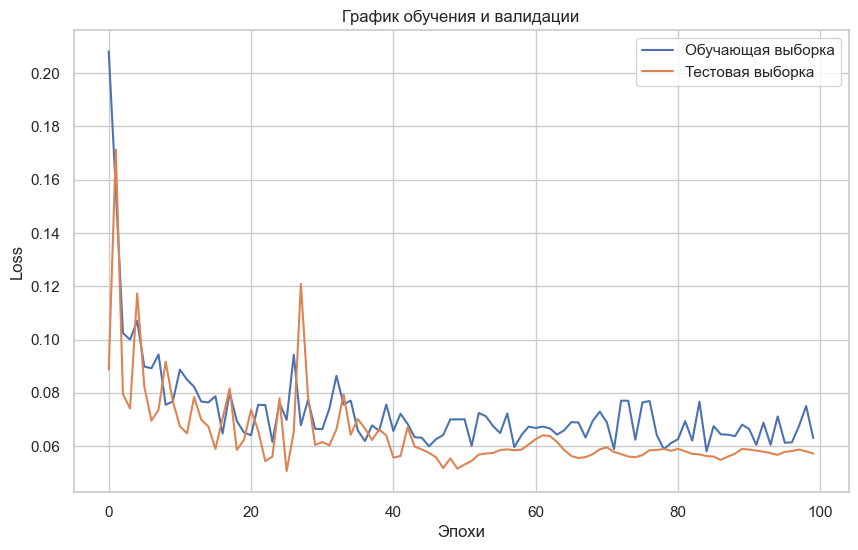

Mean Squared Error: 0.0550
R^2 Score: 0.3351


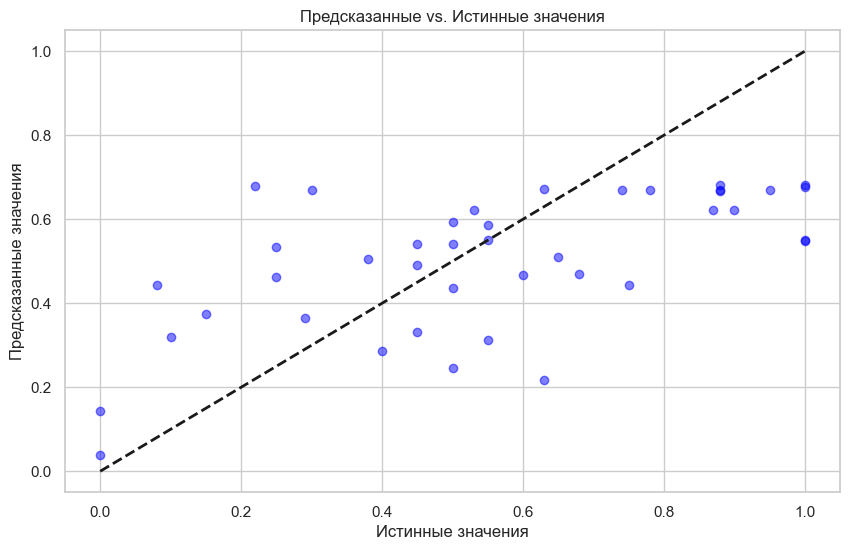

In [54]:
# Обучающий цикл
train_losses = []
test_losses = []

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))
    
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
    test_losses.append(test_loss / len(test_loader))
    
    scheduler.step()

# Графики обучения и валидации
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Обучающая выборка')
plt.plot(test_losses, label='Тестовая выборка')
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.title('График обучения и валидации')
plt.legend()
plt.show()

# Оценка модели на тестовых данных
model.eval()
with torch.no_grad():
    predictions = model(X_test).numpy()
    true_values = y_test.numpy()
    mse = mean_squared_error(true_values, predictions)
    r2 = r2_score(true_values, predictions)

print(f'Mean Squared Error: {mse:.4f}')
print(f'R^2 Score: {r2:.4f}')

# Визуализация предсказанных и истинных значений
plt.figure(figsize=(10, 6))
plt.scatter(true_values, predictions, color='blue', alpha=0.5)
plt.plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()], 'k--', lw=2)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('Предсказанные vs. Истинные значения')
plt.show()

In [55]:
class StudentPerformanceNN(nn.Module):
    def __init__(self):
        super(StudentPerformanceNN, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

model = StudentPerformanceNN()

In [56]:
# Параметры обучения
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

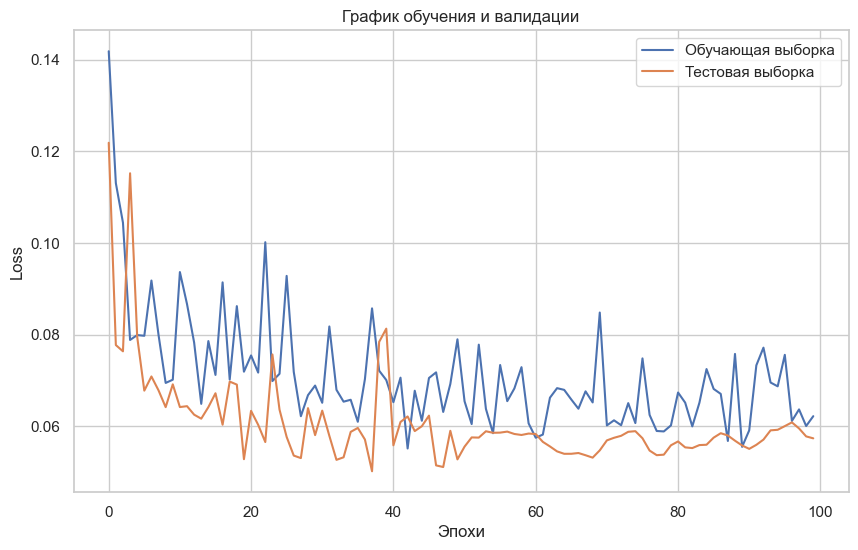

Mean Squared Error: 0.0561
R^2 Score: 0.3214


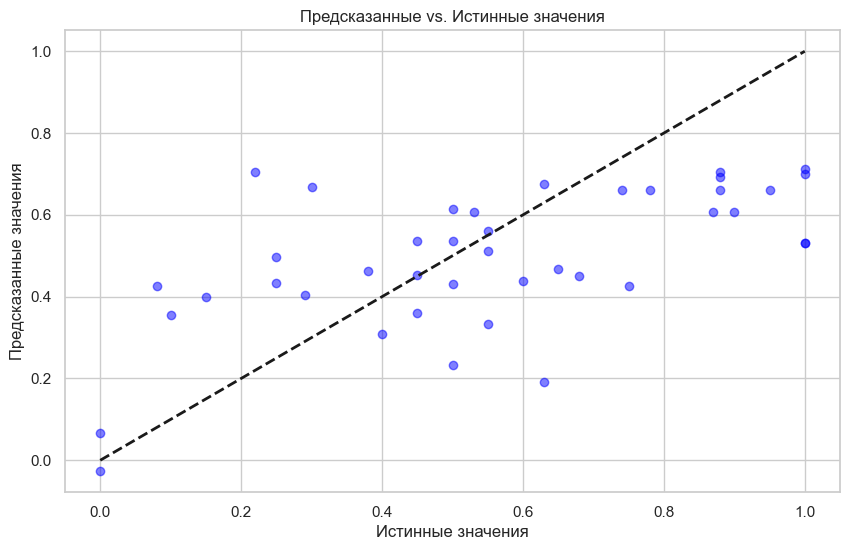

In [57]:
# Обучающий цикл
train_losses = []
test_losses = []

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))
    
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
    test_losses.append(test_loss / len(test_loader))
    
    scheduler.step()

# Графики обучения и валидации
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Обучающая выборка')
plt.plot(test_losses, label='Тестовая выборка')
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.title('График обучения и валидации')
plt.legend()
plt.show()

# Оценка модели на тестовых данных
model.eval()
with torch.no_grad():
    predictions = model(X_test).numpy()
    true_values = y_test.numpy()
    mse = mean_squared_error(true_values, predictions)
    r2 = r2_score(true_values, predictions)

print(f'Mean Squared Error: {mse:.4f}')
print(f'R^2 Score: {r2:.4f}')

# Визуализация предсказанных и истинных значений
plt.figure(figsize=(10, 6))
plt.scatter(true_values, predictions, color='blue', alpha=0.5)
plt.plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()], 'k--', lw=2)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('Предсказанные vs. Истинные значения')
plt.show()

In [59]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# Настройка кросс-валидации
kf = KFold(n_splits=5)
mse_scores = []
r2_scores = []

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Преобразование данных в тензоры
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Модель и параметры обучения
    model = StudentPerformanceNN()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

    # Обучающий цикл
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        scheduler.step()

    # Оценка модели на валидационных данных
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val).numpy()
        val_true_values = y_val.numpy()
        mse = mean_squared_error(val_true_values, val_predictions)
        r2 = r2_score(val_true_values, val_predictions)
        mse_scores.append(mse)
        r2_scores.append(r2)

# Средние значения MSE и R^2
print(f'Average MSE: {np.mean(mse_scores):.4f}')
print(f'Average R^2: {np.mean(r2_scores):.4f}')


Average MSE: 0.0745
Average R^2: -0.0031


In [60]:
# Упрощенная модель
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [61]:
# Настройка кросс-валидации
kf = KFold(n_splits=5)
mse_scores = []
r2_scores = []

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Преобразование данных в тензоры
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Модель и параметры обучения
    model = SimpleNN()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Обучающий цикл
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    # Оценка модели на валидационных данных
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val).numpy()
        val_true_values = y_val.numpy()
        mse = mean_squared_error(val_true_values, val_predictions)
        r2 = r2_score(val_true_values, val_predictions)
        mse_scores.append(mse)
        r2_scores.append(r2)

# Средние значения MSE и R^2
print(f'Average MSE: {np.mean(mse_scores):.4f}')
print(f'Average R^2: {np.mean(r2_scores):.4f}')

Average MSE: 0.0723
Average R^2: 0.0351
